In [302]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Draw, rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D
from IPython.display import display, HTML

opts = rdMolDraw2D.MolDrawOptions()
#opts.legendFontSize     = 10
opts.annotationFontScale = 1

def annotate_ligand_grid(
    df,
    ligand_col: str = "ligand_name",
    smiles_col: str = "smiles",
    rpos_col: str = "rpos",
    energy_col: str = "dE",
    cols: int = 3,
    subImgSize: tuple = (300, 300)
):
    """
    Group df by ligand_col, annotate each ligand at all its rpos with energy_col,
    and draw them in a grid.

    Returns an RDKit PIL image.
    """
    mols = []
    legends = []
    highlights = []

    for ligand, grp in df.groupby(ligand_col):
        smi       = grp[smiles_col].iloc[0]
        pos_list  = grp[rpos_col].tolist()
        e_list    = grp[energy_col].tolist()

        mol = Chem.MolFromSmiles(smi)
        if mol is None:
            raise ValueError(f"Invalid SMILES for {ligand}: {smi}")

        for pos, e in zip(pos_list, e_list):
            mol.GetAtomWithIdx(pos).SetProp("atomNote", f"{e:.2f}")

        mols.append(mol)
        legends.append(f"{ligand}: " + ", ".join(f"{p}={e:.2f}" for p, e in zip(pos_list, e_list)))
        highlights.append(pos_list)

    grid = Draw.MolsToGridImage(
        mols,
        legends=legends,
        highlightAtomLists=highlights,
        molsPerRow=cols,
        subImgSize=subImgSize,
        maxMols=len(mols),
        returnPNG=False,
        drawOptions=opts
    )
    return grid


def _svg_annotated_smi(
        smi, pos_list, dE_list,
        size=(250, 250), highlight_color=(1, 0, 0)):
    """Return an SVG string of the molecule with per-atom ΔE labels."""

    mol = Chem.MolFromSmiles(smi)
    rdDepictor.Compute2DCoords(mol)

    for p, e in zip(pos_list, dE_list):
        mol.GetAtomWithIdx(int(p)).SetProp("atomNote", f"{e:.2f}")

    drawer = rdMolDraw2D.MolDraw2DSVG(*size)
    opts = drawer.drawOptions()
    opts.drawAtomNotes       = True
    opts.annotationFontScale = 0.9 

    drawer.DrawMolecule(
        mol,
        #highlightAtoms      =[int(p) for p in pos_list],
        #highlightAtomColors ={int(p): highlight_color for p in pos_list},
    )
    drawer.FinishDrawing()
    return drawer.GetDrawingText()

def build_annotated_frame(df,
                          ligand_col="ligand_name",
                          smi_col="smiles",
                          pos_col="rpos",
                          energy_col="dE"):
    """One row per ligand + an SVG column with all ΔE annotations."""
    rows = []
    for lig, grp in df.groupby(ligand_col):
        smi  = grp[smi_col].iloc[0]
        pos  = grp[pos_col].astype(int).tolist()
        dE   = grp[energy_col].tolist()
        svg  = _svg_annotated_smi(smi, pos, dE)
        rows.append({ligand_col: lig, smi_col: smi, "annotated_svg": svg})
    return pd.DataFrame(rows)

In [303]:
conversion_factor       =  627.509474
dimer_dft               = -834847.294
HBpin_dft               = -258305.91711374212
H2_dft                  = -737.1088023791428

dimer_xtb               = -97.050557670754 * conversion_factor
HBpin_xtb               = -28.947535986441 * conversion_factor
H2_xtb                  = -0.9826859256890 * conversion_factor

In [304]:
df_lig = pd.read_parquet(
    "output_files/font_ligs.parquet",
    columns=[
        "ligand_name",
        "orca-wB97X-D3-6-31G**-Freq-electronic_energy",
        "orca-wB97X-D3-6-31G**-Freq-gibbs_energy",
        "orca-wB97X-D3-6-31+G**-NoSym-electronic_energy",
    ],
)
df_ts2 = pd.read_parquet(
    "output_files/font_ts2.parquet",
    columns=[
        "ligand_name",
        "DFT-wB97X-D3-6-31G**-OptTS-electronic_energy",
        "DFT-wB97X-D3-6-31G**-OptTS-gibbs_energy",
        "DFT-SP-wB97X-D3-6-31+G**-NoSym-electronic_energy",
    ],
)

In [305]:
df_lig

,ligand_name,orca-wB97X-D3-6-31G**-Freq-electronic_energy,orca-wB97X-D3-6-31G**-Freq-gibbs_energy,orca-wB97X-D3-6-31+G**-NoSym-electronic_energy
0,1-methylpyrrole,-249.415200,-249.332065,-249.436114
1,"2,3-dihydrothieno[3,4-b][1,4]dioxine",-780.723557,-780.640884,-780.747995
2,furan-2-yloxy(trimethyl)silane,-713.839262,-713.698698,-713.860134
3,trimethyl(pyrrol-1-yl)silane,-618.773168,-618.622349,-618.797128
4,2-tert-butylfuran,-387.198040,-387.046391,-387.217271
5,tri(propan-2-yl)-pyrrol-1-ylsilane,-854.599638,-854.283616,-854.629311
6,2-methoxyfuran,-344.451908,-344.377185,-344.470382
7,2-methylfuran,-269.273972,-269.203328,-269.290542
8,furan,-229.958568,-229.913564,-229.973386
9,1-benzylpyrrole,-480.406346,-480.245737,-480.442777


In [306]:
df = df_ts2.merge(df_lig, on='ligand_name', how='left', suffixes=('_ts', '_lig'))
df = df.drop_duplicates(subset=['ligand_name'])

In [307]:
energy_cols = [col for col in df.columns if 'energy' in col]
df[energy_cols] = df[energy_cols] * conversion_factor

In [308]:
df["lig_G_corr"] = df["orca-wB97X-D3-6-31G**-Freq-gibbs_energy"] - df["orca-wB97X-D3-6-31G**-Freq-electronic_energy"]
df["lig_G"] = df["orca-wB97X-D3-6-31+G**-NoSym-electronic_energy"] + df["lig_G_corr"]

df["ts_G_corr"] = df["DFT-wB97X-D3-6-31G**-OptTS-gibbs_energy"] - df["DFT-wB97X-D3-6-31G**-OptTS-electronic_energy"]
df["ts_G"] = df["DFT-SP-wB97X-D3-6-31+G**-NoSym-electronic_energy"] + df["ts_G_corr"]

In [309]:
df

,ligand_name,DFT-wB97X-D3-6-31G**-OptTS-electronic_energy,DFT-wB97X-D3-6-31G**-OptTS-gibbs_energy,DFT-SP-wB97X-D3-6-31+G**-NoSym-electronic_energy,orca-wB97X-D3-6-31G**-Freq-electronic_energy,orca-wB97X-D3-6-31G**-Freq-gibbs_energy,orca-wB97X-D3-6-31+G**-NoSym-electronic_energy,lig_G_corr,lig_G,ts_G_corr,ts_G
0,tri(propan-2-yl)-pyrrol-1-ylsilane,-1.211537e+06,-1.211011e+06,-1.211575e+06,-536269.369272,-536071.062623,-536287.989122,198.306648,-536089.682474,526.105081,-1.211049e+06
2,2-methylfuran,-8.442403e+05,-8.438708e+05,-8.442753e+05,-168971.968668,-168927.638834,-168982.366517,44.329834,-168938.036684,369.526504,-8.439058e+05
5,2-methoxyfuran,-8.914222e+05,-8.910501e+05,-8.914575e+05,-216146.835578,-216099.945953,-216158.428382,46.889624,-216111.538758,372.031590,-8.910854e+05
8,"2,3-dihydrothieno[3,4-b][1,4]dioxine",-1.165178e+06,-1.164800e+06,-1.165218e+06,-489911.428368,-489859.550703,-489926.763646,51.877665,-489874.885981,378.290632,-1.164840e+06
9,1-methylpyrrole,-8.317833e+05,-8.314066e+05,-8.318203e+05,-156510.401246,-156458.233204,-156523.524775,52.168042,-156471.356733,376.705875,-8.314436e+05
11,furan,-8.195661e+05,-8.192136e+05,-8.196014e+05,-144301.179744,-144272.939567,-144310.478178,28.240177,-144282.238002,352.461933,-8.192490e+05
13,trimethyl(pyrrol-1-yl)silane,-1.063565e+06,-1.063143e+06,-1.063600e+06,-388286.025021,-388191.384750,-388301.060078,94.640271,-388206.419807,421.774294,-1.063178e+06


In [310]:
print(dimer_dft)

-834847.294


In [311]:
df["dG"] = (2 * (df["ts_G"] - df["lig_G"] - HBpin_dft + H2_dft) - dimer_dft) / 2

In [312]:
df.sort_values(by="ligand_name")

,ligand_name,DFT-wB97X-D3-6-31G**-OptTS-electronic_energy,DFT-wB97X-D3-6-31G**-OptTS-gibbs_energy,DFT-SP-wB97X-D3-6-31+G**-NoSym-electronic_energy,orca-wB97X-D3-6-31G**-Freq-electronic_energy,orca-wB97X-D3-6-31G**-Freq-gibbs_energy,orca-wB97X-D3-6-31+G**-NoSym-electronic_energy,lig_G_corr,lig_G,ts_G_corr,ts_G,dG
9,1-methylpyrrole,-8.317833e+05,-8.314066e+05,-8.318203e+05,-156510.401246,-156458.233204,-156523.524775,52.168042,-156471.356733,376.705875,-8.314436e+05,20.222890
8,"2,3-dihydrothieno[3,4-b][1,4]dioxine",-1.165178e+06,-1.164800e+06,-1.165218e+06,-489911.428368,-489859.550703,-489926.763646,51.877665,-489874.885981,378.290632,-1.164840e+06,27.639278
5,2-methoxyfuran,-8.914222e+05,-8.910501e+05,-8.914575e+05,-216146.835578,-216099.945953,-216158.428382,46.889624,-216111.538758,372.031590,-8.910854e+05,18.565223
2,2-methylfuran,-8.442403e+05,-8.438708e+05,-8.442753e+05,-168971.968668,-168927.638834,-168982.366517,44.329834,-168938.036684,369.526504,-8.439058e+05,24.700783
11,furan,-8.195661e+05,-8.192136e+05,-8.196014e+05,-144301.179744,-144272.939567,-144310.478178,28.240177,-144282.238002,352.461933,-8.192490e+05,25.717017
0,tri(propan-2-yl)-pyrrol-1-ylsilane,-1.211537e+06,-1.211011e+06,-1.211575e+06,-536269.369272,-536071.062623,-536287.989122,198.306648,-536089.682474,526.105081,-1.211049e+06,32.903006
13,trimethyl(pyrrol-1-yl)silane,-1.063565e+06,-1.063143e+06,-1.063600e+06,-388286.025021,-388191.384750,-388301.060078,94.640271,-388206.419807,421.774294,-1.063178e+06,21.016416


In [313]:
df_lig_xtb = pd.read_parquet(
    "output_files/font_ligs.parquet",
    columns=[
        "ligand_name",
        "xtb-gfn-opt-electronic_energy",
    ],
)

df_ts2_xtb = pd.read_parquet(
    "output_files/font_ts2.parquet",
    columns=[
        "ligand_name",
        "xtb-gfn-opt-electronic_energy",
    ],
)

In [314]:
import pyarrow.parquet as pq

pf = pq.ParquetFile("output_files/font_ligs.parquet")
pf.schema.names

['custom_name',
 'ligand_name',
 'rpos',
 'constraint_atoms',
 'cid',
 'smiles',
 'element',
 'element',
 'energy_uff',
 'xtb-gfnff-opt-electronic_energy',
 'xtb-gfnff-opt-normal_termination',
 'element',
 'xtb-gfn-electronic_energy',
 'xtb-gfn-normal_termination',
 'xtb-gfn-opt-electronic_energy',
 'xtb-gfn-opt-normal_termination',
 'element',
 'orca-wB97X-D3-6-31G**-Freq-electronic_energy',
 'orca-wB97X-D3-6-31G**-Freq-gibbs_energy',
 'orca-wB97X-D3-6-31G**-Freq-normal_termination',
 'element',
 'frequency',
 'element',
 'orca-wB97X-D3-6-31+G**-NoSym-electronic_energy',
 'orca-wB97X-D3-6-31+G**-NoSym-normal_termination']

In [315]:
df_lig_xtb.rename(columns={"xtb-gfn-opt-electronic_energy": "xtb-gfn2-lig_energy"})

,ligand_name,xtb-gfn2-lig_energy
0,1-methylpyrrole,-17.188310
1,"2,3-dihydrothieno[3,4-b][1,4]dioxine",-27.271791
2,furan-2-yloxy(trimethyl)silane,-30.996491
3,trimethyl(pyrrol-1-yl)silane,-26.269264
4,2-tert-butylfuran,-27.314917
5,tri(propan-2-yl)-pyrrol-1-ylsilane,-45.248024
6,2-methoxyfuran,-21.878741
7,2-methylfuran,-17.816401
8,furan,-14.645031
9,1-benzylpyrrole,-32.068578


In [316]:
df_ts2_xtb = df_ts2_xtb.drop_duplicates(subset=['ligand_name'])
df_ts2_xtb

,ligand_name,xtb-gfn-opt-electronic_energy
0,tri(propan-2-yl)-pyrrol-1-ylsilane,-120.526161
2,2-methylfuran,-93.094010
5,2-methoxyfuran,-97.158426
8,"2,3-dihydrothieno[3,4-b][1,4]dioxine",-102.556176
9,1-methylpyrrole,-92.476100
11,furan,-89.920362
13,trimethyl(pyrrol-1-yl)silane,-101.562265


In [317]:
df_ts2_xtb.rename(columns={"xtb-gfn-opt-electronic_energy": "xtb-gfn2-ts2_energy"})

,ligand_name,xtb-gfn2-ts2_energy
0,tri(propan-2-yl)-pyrrol-1-ylsilane,-120.526161
2,2-methylfuran,-93.094010
5,2-methoxyfuran,-97.158426
8,"2,3-dihydrothieno[3,4-b][1,4]dioxine",-102.556176
9,1-methylpyrrole,-92.476100
11,furan,-89.920362
13,trimethyl(pyrrol-1-yl)silane,-101.562265


In [318]:
df_xtb = df_ts2_xtb.merge(df_lig_xtb, how="left", on="ligand_name", suffixes=('_ts', '_lig'))
energy_cols = [col for col in df_xtb.columns if 'energy' in col]
df_xtb[energy_cols] = df_xtb[energy_cols] * conversion_factor
df_xtb

,ligand_name,xtb-gfn-opt-electronic_energy_ts,xtb-gfn-opt-electronic_energy_lig
0,tri(propan-2-yl)-pyrrol-1-ylsilane,-75631.307908,-28393.563866
1,2-methylfuran,-58417.372988,-11179.960296
2,2-methoxyfuran,-60967.832943,-13729.117474
3,"2,3-dihydrothieno[3,4-b][1,4]dioxine",-64354.971845,-17113.307245
4,1-methylpyrrole,-58029.628918,-10785.827458
5,furan,-56425.879062,-9189.895778
6,trimethyl(pyrrol-1-yl)silane,-63731.283278,-16484.212186


In [319]:
-14.645031124933 * conversion_factor

-9189.895777920334

In [320]:
df_lig_xtb

,ligand_name,xtb-gfn-opt-electronic_energy
0,1-methylpyrrole,-17.188310
1,"2,3-dihydrothieno[3,4-b][1,4]dioxine",-27.271791
2,furan-2-yloxy(trimethyl)silane,-30.996491
3,trimethyl(pyrrol-1-yl)silane,-26.269264
4,2-tert-butylfuran,-27.314917
5,tri(propan-2-yl)-pyrrol-1-ylsilane,-45.248024
6,2-methoxyfuran,-21.878741
7,2-methylfuran,-17.816401
8,furan,-14.645031
9,1-benzylpyrrole,-32.068578


In [321]:
df_xtb["dE"] = (2 * (df_xtb["xtb-gfn-opt-electronic_energy_ts"] - df_xtb["xtb-gfn-opt-electronic_energy_lig"] - HBpin_xtb + H2_xtb) - dimer_xtb) / 2

In [322]:
df_xtb

,ligand_name,xtb-gfn-opt-electronic_energy_ts,xtb-gfn-opt-electronic_energy_lig,dE
0,tri(propan-2-yl)-pyrrol-1-ylsilane,-75631.307908,-28393.563866,760.536508
1,2-methylfuran,-58417.372988,-11179.960296,760.867858
2,2-methoxyfuran,-60967.832943,-13729.117474,759.565081
3,"2,3-dihydrothieno[3,4-b][1,4]dioxine",-64354.971845,-17113.307245,756.615950
4,1-methylpyrrole,-58029.628918,-10785.827458,754.479089
5,furan,-56425.879062,-9189.895778,762.297266
6,trimethyl(pyrrol-1-yl)silane,-63731.283278,-16484.212186,751.209458


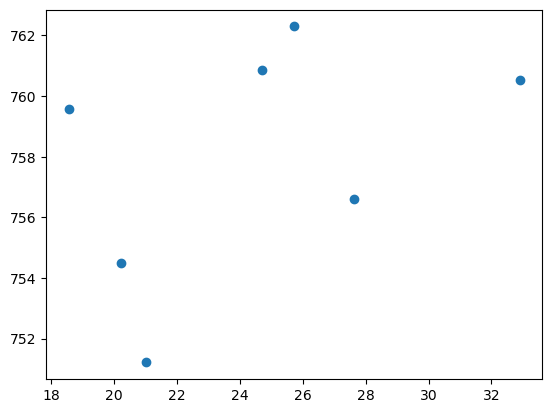

In [323]:
import matplotlib.pyplot as plt

plt.scatter(df["dG"], df_xtb["dE"])

In [325]:
df1 = pd.read_parquet("output_files/font_ligs.parquet")
df1

,custom_name,ligand_name,rpos,constraint_atoms,cid,smiles,atoms,coords_embedded,energy_uff,xtb-gfnff-opt-electronic_energy,...,xtb-gfn-opt-electronic_energy,xtb-gfn-opt-normal_termination,xtb-gfn-opt-opt_coords,orca-wB97X-D3-6-31G**-Freq-electronic_energy,orca-wB97X-D3-6-31G**-Freq-gibbs_energy,orca-wB97X-D3-6-31G**-Freq-normal_termination,orca-wB97X-D3-6-31G**-Freq-opt_coords,orca-wB97X-D3-6-31G**-Freq-vibs,orca-wB97X-D3-6-31+G**-NoSym-electronic_energy,orca-wB97X-D3-6-31+G**-NoSym-normal_termination
0,CN1C=CC=C1_1-methylpyrrole,1-methylpyrrole,None,None,5,None,"[C, N, C, C, C, C, H, H, H, H, H, H, H]","[[1.901870289570235, 0.06566438926249234, 0.00...",None,-2.418193,...,-17.188310,True,"[[1.86162046085733, 0.05712764761933, 0.023047...",-249.415200,-249.332065,True,"[[1.871103, 0.057473, 0.015262], [0.426034, 0....","[{'frequency': 66.47, 'mode': [[-0.000244 0.0...",-249.436114,True
1,"C12=CSC=C1OCCO2_2,3-dihydrothieno[3,4-b][1,4]d...","2,3-dihydrothieno[3,4-b][1,4]dioxine",None,None,21,None,"[C, C, S, C, C, O, C, C, O, H, H, H, H, H, H]","[[0.6698110489179192, 0.6368450733788671, 0.24...",None,-2.614358,...,-27.271791,True,"[[0.60981376630919, 0.70289956852261, 0.237274...",-780.723557,-780.640884,True,"[[0.615363, 0.705071, 0.244766], [1.84382, 1.2...","[{'frequency': 110.21, 'mode': [[-0.011944 -0....",-780.747995,True
2,C[Si](C)(OC1=CC=CO1)C_furan-2-yloxy(trimethyl)...,furan-2-yloxy(trimethyl)silane,None,None,22,None,"[C, Si, C, O, C, C, C, C, O, C, H, H, H, H, H,...","[[-0.7840774279768576, -0.13952974087861436, 1...",None,-3.585101,...,-30.996491,True,"[[-0.88218387438664, 0.34826535983198, 2.06614...",-713.839262,-713.698698,True,"[[-0.842518, 0.376868, 2.007009], [-1.188296, ...","[{'frequency': 16.99, 'mode': [[-0.154437 -0.0...",-713.860134,True
3,C[Si](N1C=CC=C1)(C)C_trimethyl(pyrrol-1-yl)silane,trimethyl(pyrrol-1-yl)silane,None,None,9,None,"[C, Si, N, C, C, C, C, C, C, H, H, H, H, H, H,...","[[-1.9254451732295033, -0.6655141486958103, -1...",None,-3.661086,...,-26.269264,True,"[[-1.83314476629126, -0.73097762739336, -1.287...",-618.773168,-618.622349,True,"[[-1.835564, -0.688707, -1.273722], [-0.920335...","[{'frequency': -16.73, 'mode': [[ 0.013363 -0....",-618.797128,True
4,CC(C1=CC=CO1)(C)C_2-tert-butylfuran,2-tert-butylfuran,None,None,7,None,"[C, C, C, C, C, C, O, C, C, H, H, H, H, H, H, ...","[[-0.7705814104760014, 0.8009883887328766, -1....",None,-3.543296,...,-27.314917,True,"[[-0.85428764843631, 0.87604914062269, -1.4808...",-387.198040,-387.046391,True,"[[-0.858571, 0.867789, -1.485761], [-0.776737,...","[{'frequency': 50.0, 'mode': [[0.006278 0.1245...",-387.217271,True
5,CC([Si](N1C=CC=C1)(C(C)C)C(C)C)C_tri(propan-2-...,tri(propan-2-yl)-pyrrol-1-ylsilane,None,None,79,None,"[C, C, Si, N, C, C, C, C, C, C, C, C, C, C, C,...","[[-1.6469087827335982, -0.7048999269573131, 2....",None,-6.327760,...,-45.248024,True,"[[-1.97225758529225, -0.18537986560273, 2.1513...",-854.599638,-854.283616,True,"[[-1.986602, -0.156936, 2.121306], [-1.804573,...","[{'frequency': 25.04, 'mode': [[ 0.03604 -0.0...",-854.629311,True
6,COC1=CC=CO1_2-methoxyfuran,2-methoxyfuran,None,None,34,None,"[C, O, C, C, C, C, O, H, H, H, H, H, H]","[[2.409145115377121, 0.19594811217862987, -0.1...",None,-2.325961,...,-21.878741,True,"[[2.29918004653874, 0.26830206733918, -0.07973...",-344.451908,-344.377185,True,"[[2.297333, 0.280013, -0.079896], [1.356452, -...","[{'frequency': -16.37, 'mode': [[-0.006901 -0....",-344.470382,True
7,CC1=CC=CO1_2-methylfuran,2-methylfuran,None,None,41,None,"[C, C, C, C, C, O, H, H, H, H, H, H]","[[-1.8873104967913783, 0.21972371261492993, 0....",None,-2.201913,...,-17.816401,True,"[[-1.89557651838898, 0.23910941433334, 0.05149...",-269.273972,-269.203328,True,"[[-1.895605, 0.248725, 0.05427], [-0.420468, 0...","[{'frequency': 120.37, 'mode': [[ 0.000406 -0....",-269.290542,True
8,C1=CC=CO1_furan,furan,None,None,32,None,"[C, C, C, C, O, H, H, H, H]","[[0.888690999246738, -0.7499341898567017, 0.19...",None,-1.7